System information (for reproducibility):

In [1]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  CPU: 10 × Apple M1 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores


Load packages:

In [2]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Downloads/SSS/Bio257_23Spring/HW/hw2`


Status `~/Downloads/SSS/Bio257_23Spring/HW/hw2/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [7073ff75] IJulia v1.24.0
  [916415d5] Images v0.25.2
  [bdcacae8] LoopVectorization v0.12.157
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra
  [9abbd945] Profile


In [3]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, LoopVectorization
using Profile, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an alternative to principal components and vector quantization with applications in data compression, clustering, and deconvolution. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates the iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

In [4]:
import LinearAlgebra: BlasReal, copytri!

function nnmf(
    X       :: Matrix{T}, 
    r       :: Integer;
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r),
    W       :: Matrix{T} = rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    rr_storage = Matrix{T}(undef, r, r)
    storage_V1 = similar(V)
    storage_V2 = similar(V)
    storage_W1 = similar(W)
    storage_W2 = similar(W)
    storage_X = similar(X)
    x2norm = abs2(norm(X))
    
    X_err = similar(X)
    
    obj_old = 0
    obj = 0
#    fill!(rr_storage, 0)
    niter = maxiter
    for iter in 1:maxiter
        #TODO: how to get rid of unnecessary allocation.
        mul!(rr_storage, W, transpose(W))
        mul!(storage_V2, V, rr_storage)
        mul!(storage_V1, X, transpose(W))
        
#        V .= V .* storage_V1 ./ storage_V2
#        V .*= storage_V1
#        V ./= storage_V2
        for idx in eachindex(V)
            V[idx] *= storage_V1[idx]
            V[idx] /= storage_V2[idx]
        end
#        rr_storage .= transpose(V) * V
#        BLAS.syrk!('U', 'T', one(T), V, zero(T), rr_storage)
#        rr_storage .= Symmetric(rr_storage)
        mul!(rr_storage, transpose(V), V)
        mul!(storage_W2, rr_storage, W)
        mul!(storage_W1, transpose(V), X)
        
        obj_old = obj
        obj = x2norm
        for idx in eachindex(W)
            obj += (storage_W2[idx] - 2 * storage_W1[idx]) * W[idx]
            W[idx] *= storage_W1[idx]
            W[idx] /= storage_W2[idx]
        end
#        W .= W .* storage_W1 ./ storage_W2
        X_err .= X
        mul!(X_err, V, W, -one(T), one(T))
#        
#        obj = sum(X_err .* X_err)
        if abs(obj - obj_old) <= tolfun * (abs(obj_old) + 1)
            niter = iter
            break 
        end
    end
    
    if niter == maxiter
        @warn "maxiter reached without convergence"
    end
    # implementation
    # Output
    V, W, obj, niter
end

nnmf (generic function with 1 method)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu/software-datasets/FaceData2.html) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple of sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

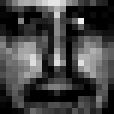

In [5]:
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

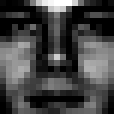

In [6]:
colorview(Gray, reshape(X[12, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@btime`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  162.662 ms (9 allocations: 437.19 KiB)
obj=11730.866905748058, niter=239
r=20
  234.293 ms (9 allocations: 875.44 KiB)
obj=8497.605595863002, niter=394
r=30
  259.524 ms (9 allocations: 1.28 MiB)
obj=6621.94596847528, niter=482
r=40
  289.918 ms (9 allocations: 1.72 MiB)
obj=5256.866299829562, niter=581
r=50
  397.511 ms (10 allocations: 2.15 MiB)
obj=4430.362097310877, niter=698
```
Due to machine differences, your run times can be different from mine but certainly can not be order of magnitude longer. Your memory allocation should be less or equal to mine.

## Solution Q1.3

In [7]:
V0full = readdlm("V0.txt")
W0full = readdlm("W0.txt")

r = 50
V0_ref = similar(V0full[:, 1:r])
W0_ref = similar(W0full[1:r, :])

obj = 0
niter = 0
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    if (r == 50)
        V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
        V0_ref .= V
        W0_ref .= W
    else
        _, _, obj, niter = nnmf(X, r; V = V0, W = W0)
    end
    @btime nnmf($X, $r; V = $V0, W = $W0)
    println("obj=$obj, niter=$niter")
end

r=10
  3.920 ms (15 allocations: 13.81 MiB)
obj=11728.547948790188, niter=2
r=20
  4.593 ms (15 allocations: 14.24 MiB)
obj=8495.940996629568, niter=2
r=30
  5.301 ms (15 allocations: 14.66 MiB)
obj=6620.630487323468, niter=2
r=40
  5.855 ms (15 allocations: 15.10 MiB)
obj=5255.825931542437, niter=2
r=50
  6.994 ms (16 allocations: 15.53 MiB)
obj=4429.482800161475, niter=2


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

In [8]:
Random.seed!(1234)
r = 50
@time V0_50, W0_50, obj, niter = nnmf(X, r)

  1.643419 seconds (20.18 k allocations: 17.372 MiB, 1.84% compilation time)


([1.936302866519159e-14 0.03444776944437119 … 0.0370770054831084 6.022353719870616e-34; 0.0010504868932476015 0.027078794704269937 … 0.030330570910909356 1.080508727146923e-23; … ; 0.024082651367591506 0.023551973331618622 … 0.014266332917605734 0.009665975466860158; 0.00957112624235055 2.3974305851583187e-13 … 0.013623342313066797 0.016521169902849134], [9.857313321334958e-40 3.86916070677741e-27 … 8.885784753325514e-17 6.904802077966577e-45; 1.5161464118877119e-37 5.578410179465069e-23 … 6.867286074086178e-9 9.888883589391405e-45; … ; 3.250271743619598 1.4772357361218347 … 7.176985994916491e-10 2.4793350543857632e-8; 5.4133032992759515e-58 1.2843469418660428e-29 … 2.220726779682269e-8 2.1768206564119626e-55], 4481.82566709832, 612)

In [9]:
norm(V0_ref - V0_50)

6.365943769265134

In [10]:
norm(W0_ref - W0_50)

293.4915800111663

The resulting numbers and iteration are approximately the same, but the objective value and $(V,W)$
 are noticeably different than before: W in particular deviates from the reference noticeably more than does V
 for the different starting point, suggesting that the decomposition is not unique for a given matrix and may vary depending on the starting matrices.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

## Solution Q 1.5

In [11]:
r = 50
V = ones((size(X, 1), r))
W = ones((r, size(X, 2)))
@time V0_50, W0_50, obj, niter = nnmf(X, r; V = V, W = W)

  0.018003 seconds (28 allocations: 15.529 MiB)


([0.005474678688547898 0.005474678688547898 … 0.005474678688547898 0.005474678688547898; 0.005441387722114405 0.005441387722114405 … 0.005441387722114405 0.005441387722114405; … ; 0.005704039080945006 0.005704039080945006 … 0.005704039080945006 0.005704039080945006; 0.005606185103016937 0.005606185103016937 … 0.005606185103016937 0.005606185103016937], [0.3699517799476869 0.4606586011069409 … 0.5580793952009446 0.42552103824346577; 0.3699517799476869 0.4606586011069409 … 0.5580793952009446 0.42552103824346577; … ; 0.3699517799476869 0.4606586011069409 … 0.5580793952009446 0.42552103824346577; 0.3699517799476869 0.4606586011069409 … 0.5580793952009446 0.42552103824346577], 25297.01577848839, 4)

In [12]:
norm(V0_ref - V0_50)

4.8937247088304465

In [13]:
norm(W0_ref - W0_50)

222.19895804881068

The value of $V$ is very close to that of the reference $V$, but not so for $W$. The differences are noticeably similar in order of magnitude to those of the random $V^{(0)}$ and $W^{(0)}$ above from the preceding example with random matrices.

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

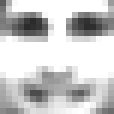

In [14]:
colorview(Gray, reshape(W[1, :], 19, 19))

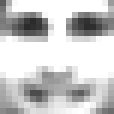

In [15]:
colorview(Gray, reshape(W[5, :], 19, 19))

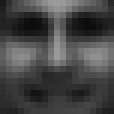

In [16]:
colorview(Gray, reshape((V * W)[1,:], 19, 19))

### Q1.7 GPU (optional)

Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.